In [1]:
import dotenv 
import chromadb
from openai import OpenAI
import os 
from PyPDF2 import PdfReader
import os
import requests
import tqdm
import pandas as pd
import numpy as np 
from textwrap3 import wrap
import itertools


/Users/brighttenkorangofori/Desktop/RAG/chroma-exp/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
OPENAI_KEY = os.getenv('OPENAI_API_KEY')

In [4]:

client = OpenAI(api_key=OPENAI_KEY)

In [5]:
def load_file(filepath=None):
    """function loads file if filepath is found else  downloads it 

    Args: file_path of document to load 
    
    
    Returns: pages_and_content = {'number' : [],
                         'text' : [],
                          'word_count' : [],
                           'sentence_count' : [],
                           'token_count' : []}
    
    
    """
    pages_and_content = {'number' : [],
                         'text' : [],
                          'word_count' : [],
                           'sentence_count' : [],
                           'token_count' : []}
    
    if os.path.isfile(filepath):
        print('File found, loading...')
        reader = PdfReader(filepath)
        for i, page in enumerate(reader.pages):
            # page_text = clean_text(page.extract_text())  # Uncomment and use if you have a clean_text function
            page_text = str(page.extract_text())
            #page_text = shallow_clean(page_text)
            word_count = len(page_text.split(' '))
            sentence_count = len(page_text.split('.'))
            token_count = len(page_text)/4
            
            pages_and_content['number'].append(i)
            pages_and_content['text'].append(str(page_text))
            pages_and_content['sentence_count'].append(sentence_count)
            pages_and_content['token_count'].append(token_count)
            pages_and_content['word_count'].append(word_count)
        return pages_and_content
    
    else: 
        print('File not available, downloading...')
        response = requests.get(filepath,timeout=30)
        if response.status_code == 200:
            print('File downloaded, saving...')
            with open('data.pdf', 'wb') as f:
                f.write(response.content)
                print('Data saved!')
            reader = PdfReader('data.pdf')
            for i, page in enumerate(reader.pages):
                # page_text = clean_text(page.extract_text())  # Uncomment and use if you have a clean_text function
                page_text = str(page.extract_text())
                #page_text = shallow_clean(page_text)
                word_count = len(page_text.split(' '))
                sentence_count = len(page_text.split('.'))
                token_count = len(page_text)/4
                
                pages_and_content['number'].append(i)
                pages_and_content['text'].append(str(page_text))
                pages_and_content['sentence_count'].append(sentence_count)
                pages_and_content['token_count'].append(token_count)
                pages_and_content['word_count'].append(word_count)

            return pages_and_content 
        else:
            print('Failed to download file')
            return None

In [6]:
file_path = '/Users/brighttenkorangofori/Downloads/2022_Annual_Report.pdf'

In [7]:
pages_and_content = load_file(file_path)

File found, loading...


In [8]:
def get_openai_response(user_content,model, temperature,client,system_content = 'you are a helpful assistant'):
    messages = [{'role':'system',
                'content': system_content},
                {'role':'user',
                'content': user_content }]
    response = client.chat.completions.create(model = model,
                                        messages = messages,
                                        temperature = temperature)
    return response.choices[0].message.content


In [9]:
response1 = get_openai_response(user_content='how do i learn javascript',
                    model = 'gpt-3.5-turbo',
                    client = client,
                    temperature = 0.6)





In [10]:
response1

'Learning JavaScript can be a rewarding experience! Here are some steps you can take to start learning:\n\n1. **Online resources**: There are many online resources available for learning JavaScript, such as tutorials, courses, and documentation. Websites like Codecademy, freeCodeCamp, and Mozilla Developer Network offer free tutorials and courses for beginners.\n\n2. **Books**: There are also many books available on JavaScript that can help you learn the language in-depth. Some popular books include "Eloquent JavaScript" by Marijn Haverbeke and "JavaScript: The Good Parts" by Douglas Crockford.\n\n3. **Practice**: The best way to learn JavaScript is by practicing coding. Try to work on small projects or challenges to apply what you have learned and improve your skills.\n\n4. **Join a community**: Joining online communities like Stack Overflow, Reddit\'s r/learnjavascript, or joining local meetups can help you connect with other learners and experienced developers who can provide guidan

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(separators=['\n','.'])
doc_chunks = []
docs = pages_and_content['text']
for page in pages_and_content['text']:
        chunks = text_splitter.split_text(page)
        doc_chunks.append(chunks)
doc_chunks = list(itertools.chain.from_iterable(doc_chunks))
    

In [12]:
from itertools import chain


In [13]:
len(doc_chunks)

115

In [14]:

docs_df = pd.DataFrame(pages_and_content)
docs_df.head(3)

,number,text,word_count,sentence_count,token_count
0,0,\n,4,1,1.0
1,1,,1,1,0.0
2,2,"1 Dear shareholders, colleagues, customers, an...",613,27,928.0


In [16]:
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
Token_Splitter =  SentenceTransformersTokenTextSplitter(chunk_overlap = 0,tokens_per_chunk = 256)

    

In [17]:
def token_split(Token_Splitter,doc_chunks):
    token_splits =[]
    for text in doc_chunks:
        token_split = Token_Splitter.split_text(text)
        token_splits.append(token_split)
    return token_splits

In [47]:
token_splits = token_split(Token_Splitter,doc_chunks)


In [48]:
len(token_splits)

115

In [52]:
token_splits = [item for sublist in token_splits for item in sublist]


In [20]:
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

#connecting to chroma and creating collection
embedding_fcn = SentenceTransformerEmbeddingFunction()
database_path = '/Users/brighttenkorangofori/Desktop/chromadb'
chroma_client = chromadb.PersistentClient(path =database_path)
collection = chroma_client.get_or_create_collection(name='microsoft',embedding_function=embedding_fcn)
#addding ids and documents to collection 


In [55]:
ids = [str(i) for i in range(len(token_splits))]
collection.add(ids = ids,documents= token_splits)

In [56]:
#gets all embeddings from documents in database
embeddings = collection.get(include=['embeddings','documents'])['embeddings']

In [57]:
query = ['what was the total revenue for the year']
query_embeding = embedding_fcn(query)
results = collection.query(query_texts=query,n_results=5,include=['embeddings','documents'])

In [61]:
#document results from single query
results['documents']

[['amortization period would have been one year or less. these costs include our internal sales force compensation program and certain partner sales incentive programs as we have determined annual compensation is commensurate with annual sales activities. cost of revenue cost of revenue includes : manufacturing and distribution costs for products sold and programs licensed ; operating costs related to product support service centers and product distribution centers ; costs incurred to include software on pcs sold by original equipment manufacturers ( “ oem ” ), to drive traffic to our websites, and to acquire online',
  '50 cash flows statements ( in millions ) year ended june 30, 2022 2021 2020 operations net income $ 72, 738 $ 61, 271 $ 44, 281 adjustments to reconcile net income to net cash from operations : depreciation, amortization, and other 14, 460 11, 686 12, 796 stock - based compensation expense 7, 502 6, 118 5, 289 net recognized gains on investments and derivatives ( 409 )

In [59]:
np.array(query_embeding).shape

(1, 384)

In [62]:
def supplement_queries(query, client, num_queries):
    """
    Args:
        query: The main question to generate supplementary questions for.
        client: The OpenAI API client.
        num_queries: The number of supplementary questions to generate.

    Returns:
        A list of supplementary questions related to the main query.
    """
    model = 'gpt-3.5-turbo'
    temperature = 0.6
    prompt = f"""
    You are a knowledgeable financial research assistant. 
    Your users are inquiring about an annual report. 
    For the given question, propose up to {num_queries} related questions to assist them in finding the information they need. 
    Provide concise, single-topic questions (without compounding sentences) that cover various aspects of the topic. 
    Ensure each question is complete and directly related to the original inquiry. 
    List each question on a separate line without numbering.
    """

    try:
        response = get_openai_response(
            user_content=query,
            model=model,
            client=client,
            temperature=temperature,
            system_content=prompt
        )
        return response
    except ConnectionError as e:
        return f'{e} could not fetch result'



In [63]:
generated_queries = supplement_queries(query[0],client,5)


In [64]:
#converts to list
generated_queries = generated_queries.splitlines(keepends=False)

In [185]:
# 5 extra questions to supplement 'what was the total revenue for the year'
generated_queries

list

In [66]:
# we are reassigning generated queries to joint_query
joint_query = query +generated_queries 

In [67]:
joint_query

['what was the total revenue for the year',
 '- What were the sources of revenue for the company during the year?',
 '- How does the total revenue for the year compare to the previous year?',
 '- Did the company experience any significant fluctuations in revenue throughout the year?',
 "- What percentage of the total revenue came from the company's core business operations?",
 '- Were there any one-time or unusual revenue items that impacted the total revenue for the year?']

In [68]:
#gettinng the augmented queries from our documents through similarity search

joint_query_results = collection.query(query_texts=joint_query,n_results=5,include=['embeddings','documents'])

In [69]:
# 5 documnets returned for each of the 6 queries
joint_query_results['documents']

[['amortization period would have been one year or less. these costs include our internal sales force compensation program and certain partner sales incentive programs as we have determined annual compensation is commensurate with annual sales activities. cost of revenue cost of revenue includes : manufacturing and distribution costs for products sold and programs licensed ; operating costs related to product support service centers and product distribution centers ; costs incurred to include software on pcs sold by original equipment manufacturers ( “ oem ” ), to drive traffic to our websites, and to acquire online',
  '50 cash flows statements ( in millions ) year ended june 30, 2022 2021 2020 operations net income $ 72, 738 $ 61, 271 $ 44, 281 adjustments to reconcile net income to net cash from operations : depreciation, amortization, and other 14, 460 11, 686 12, 796 stock - based compensation expense 7, 502 6, 118 5, 289 net recognized gains on investments and derivatives ( 409 )

In [70]:
def augment_query_results(query):
    """Args: Takes a question
    
     Returns: An answer from LLM using documents results as context"""
    results = collection.query(query_texts=query,n_results=5)
    context = results['documents']
    user_content = f" You are an expert financial analyzer who provides responses to {query} using {context}"
    messages = [{'role':'system',
                 'content': user_content},
                 {'role':'user',
                 'content': query}]
    response = client.chat.completions.create(messages= messages,
                                              model='gpt-3.5-turbo',
                                              temperature = 0.5)
    answer = response.choices[0].message.content
    return answer


In [71]:
import umap

def project_embeddings(embeddings, umap_transform):
    """
    Projects the given embeddings using the provided UMAP transformer.

    Args:
    embeddings (numpy.ndarray): The embeddings to project.
    umap_transform (umap.UMAP): The trained UMAP transformer.

    Returns:
    numpy.ndarray: The projected embeddings.
    """
    projected_embeddings = umap_transform.transform(embeddings)
    return projected_embeddings


/Users/brighttenkorangofori/Desktop/RAG/chroma-exp/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
joint_query

['what was the total revenue for the year',
 '- What were the sources of revenue for the company during the year?',
 '- Can you provide a breakdown of the revenue by product/service category?',
 '- How does the total revenue for the year compare to the previous year?',
 '- Were there any significant one-time or non-recurring revenue items that impacted the total revenue?',
 '- What were the main factors that drove changes in the total revenue for the year?']

In [100]:
#get data from collection using joint queries
joint_query_results = collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"])


In [101]:
len(joint_query),len(joint_query_results['documents'])

(6, 6)

In [74]:
for i in range(len(joint_query)):
    print(f"Query: {joint_query[i]}  Result:{joint_query_results['documents'][i]}")
    print('-'*1000)

Query: what was the total revenue for the year  Result:['amortization period would have been one year or less. these costs include our internal sales force compensation program and certain partner sales incentive programs as we have determined annual compensation is commensurate with annual sales activities. cost of revenue cost of revenue includes : manufacturing and distribution costs for products sold and programs licensed ; operating costs related to product support service centers and product distribution centers ; costs incurred to include software on pcs sold by original equipment manufacturers ( “ oem ” ), to drive traffic to our websites, and to acquire online', '50 cash flows statements ( in millions ) year ended june 30, 2022 2021 2020 operations net income $ 72, 738 $ 61, 271 $ 44, 281 adjustments to reconcile net income to net cash from operations : depreciation, amortization, and other 14, 460 11, 686 12, 796 stock - based compensation expense 7, 502 6, 118 5, 289 net rec

In [102]:
#reduce joint query results into single results(flatten-list)
joint_query_results_documents= []
for sublist in joint_query_results['documents']:
    for sub in sublist:
        joint_query_results_documents.append(sub)

len(joint_query_results_documents)

30

In [103]:
#remove duplicate documents
unique_documents = set()
for answers in results['documents']:
    for answer in answers:
        unique_documents.add(answer)
unique_documents = list(unique_documents)

In [104]:
unique_documents

['50 cash flows statements ( in millions ) year ended june 30, 2022 2021 2020 operations net income $ 72, 738 $ 61, 271 $ 44, 281 adjustments to reconcile net income to net cash from operations : depreciation, amortization, and other 14, 460 11, 686 12, 796 stock - based compensation expense 7, 502 6, 118 5, 289 net recognized gains on investments and derivatives ( 409 ) ( 1, 249 ) ( 219 ) deferred income taxes ( 5, 702 ) ( 150 ) 11 changes in operating assets and liabilities : accounts receivable ( 6, 834 ) ( 6, 481 ) ( 2, 577 ) inventories ( 1, 123 ) ( 737 ) 168 other current assets ( 709 ) ( 932 ) ( 2, 330 ) other long - term assets ( 2, 805 ) ( 3, 459 ) ( 1, 037 ) accounts payable 2, 943 2, 798 3, 018 unearned revenue 5, 109 4, 633 2, 212 income taxes 696 ( 2, 309 ) ( 3, 631 ) other current liabilities 2, 344 4, 149 1, 346 other long - term',
 'amortization period would have been one year or less. these costs include our internal sales force compensation program and certain partner

In [105]:
dataset_embeddings = collection.get(include=['embeddings'])['embeddings']
len(dataset_embeddings)

278

In [106]:
np.array(dataset_embeddings).shape

(278, 384)

In [125]:

#all embeddings for the joint query
joint_query_results_embeddings = joint_query_results['embeddings']

#joint_query_results_embeddings = [item for sublist in joint_query_results_embeddings for item in sublist ]


In [126]:
joint_query_results_embeddings = [item for sublist in joint_query_results_embeddings for item in sublist]


In [127]:
np.array(joint_query_results_embeddings).shape,len(joint_query_results_embeddings)

((30, 384), 30)

In [117]:


#projection object
umap_transform = umap.UMAP(random_state=0,transform_seed=0).fit(embeddings)
#converts original query into embedding
single_query_embedding = embedding_fcn(query)

project_single_query = project_embeddings(single_query_embedding,umap_transform)

#all embeddings for single query
single_query_result_embeddings = results['embeddings']

#flattened list
single_query_result_embeddings = list(itertools.chain.from_iterable(single_query_result_embeddings))

#project single query results
project_single_query_results = project_embeddings(single_query_result_embeddings,umap_transform)


/Users/brighttenkorangofori/Desktop/RAG/chroma-exp/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [128]:
joint_query_embeddings = embedding_fcn(joint_query)


#project joint queries
project_joint_queries = project_embeddings(
    joint_query_embeddings, umap_transform)

project_joint_query_results_embeddings = project_embeddings(joint_query_results_embeddings,umap_transform)


In [130]:
import matplotlib.pyplot as plt 

def plot_projections(projected_dataset_embeddings,
                     project_single_query,project_single_query_results,
                     project_joint_queries,
                     project_joint_query_results_embeddings):
    plt.figure()

    #plot all embddings in dataset
    plt.scatter(
        projected_dataset_embeddings[:, 0],
        projected_dataset_embeddings[:, 1],
        s=10,
        color="gray",
    )
    #plot location of original query
    plt.scatter(project_single_query[:,0],project_single_query[:,1],color = 'blue',label = 'original query')

    plt.scatter(project_single_query_results[:,0],project_single_query_results[:,1],color = 'black',label = 'original query results')

    #plot location of augmented queries
    plt.scatter(project_joint_queries[:,0],project_joint_queries[:,1],color = 'red',label = 'augmented queries')

    #plot result document location of joint query results 
    plt.scatter(project_joint_query_results_embeddings[:,0],project_joint_query_results_embeddings[:,1],color = 'green',label = 'augmented query results')

    #plot result location of joint query


    plt.title('Comparison Of Similarity Search for Naive RAG and Expansion Query RAG in Database')
    plt.legend()

In [133]:
projected_dataset_embeddings = project_embeddings(embeddings,umap_transform)

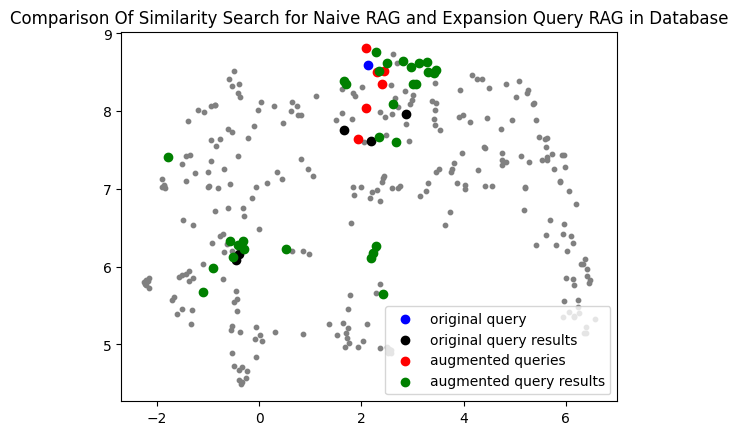

In [134]:
plot_projections(projected_dataset_embeddings,
                     project_single_query,project_single_query_results,
                     project_joint_queries,
                     project_joint_query_results_embeddings)

In [ ]:
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain_core.vectorstores import VectorStoreRetriever
retriever = VectorStoreRetriever(vectorstore=F)
llm = OpenAI(api_key=OPENAI_KEY)
langchainChroma = Chroma(client = chroma_client,
                          collection_name = 'microsoft',
                            embedding_function=embedding_fcn,
                         persist_directory=database_path)

retriever = VectorStoreRetriever('name')

qa = RetrievalQA.from_llm(llm=llm, retriever=retriever)


query = """what is the total profit"""
result = qa.run(query)
print(result)

In [162]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings

chroma_db = Chroma(collection_name='microsoft',
                   embedding_function= embedding_fcn,
                   persist_directory=database_path)
retriever = chroma_db.as_retriever()  # Your retriever
llm = ChatOpenAI()

system_prompt = (
    "Use the given context to answer the question. "
    "If you don't know the answer, say you don't know. "
    "Use three sentence maximum and keep the answer concise. "
    "Context: {context}"
)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, prompt)
chain = create_retrieval_chain(retriever, question_answer_chain)


chain.invoke({"input": query})

AttributeError: 'SentenceTransformerEmbeddingFunction' object has no attribute 'embed_query'

In [171]:
#from torch.utils. import pairwise
def naive_rag_search(query,client,collection,embeddings):

    umap_transform = umap.UMAP(random_state=0,transform_seed=0).fit(embeddings)

    results = collection.query(query_texts=query,n_results=5,include=['embeddings','documents'])
    context = results['documents']
    
    single_query_embedding = embedding_fcn([query])
    result_embeddings = results['embeddings']
    result_embeddings = [ item for sublist in result_embeddings for item in sublist ]
    
    
    #project single query results
    project_single_query_results = project_embeddings(result_embeddings,umap_transform)
    project_single_query = project_embeddings(single_query_embedding,umap_transform)
    

    system_content = f"""
    You are a knowledgeable financial research assistant. 
    Your users are inquiring about an annual report. 
    For the given question,   assist them in finding the information they need. 
    Provide concisw answers based on {context} 
    Ensure the answer is complete and directly related to the original {query}. 
    
    """
   


    answer = get_openai_response(user_content=query,
                                 model = 'gpt-3.5-turbo',
                                 system_content=system_content,
                                 client = client,
                                 temperature=0.5)
    
    
    return answer
    
    






/Users/brighttenkorangofori/Desktop/RAG/chroma-exp/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [176]:
from textwrap3 import TextWrapper

answer = naive_rag_search(query,client,collection,embeddings)
text_wrapper = TextWrapper(width= 50)

text_wrapper.wrap(answer)

['The total revenue for the year is $198,270',
 'million. This represents an 18% increase compared',
 "to last year's total revenue of $168,088 million."]

In [227]:
#from torch.utils. import pairwise
def expansion_rag_search(query,client,collection,embeddings):

    umap_transform = umap.UMAP(random_state=0,transform_seed=0).fit(embeddings)
    generated_queries = supplement_queries(query,client,5)
    generated_queries = generated_queries.splitlines(keepends=False)

    joint_queries = [query] + generated_queries
    
    results = collection.query(query_texts=joint_query,n_results=5,include=['embeddings','documents'])
    
    context = results['documents']
    #print(len(context))
    
    context = [item for sublist in context for item in sublist ]
    #print(f'new context:{len(context)}')
    unique_context = set(context)

    

    query_embeddings = embedding_fcn(joint_queries)


    result_embeddings = results['embeddings']
    result_embeddings = [ item for sublist in result_embeddings for item in sublist ]
    unique_context_embeddings = embedding_fcn(unique_context)

    print(len(result_embeddings))
    print(np.array(unique_context_embeddings).shape)
    #result_embeddings = set(result_embeddings)
    
    #project single query results
    project_query_results = project_embeddings(unique_context_embeddings,umap_transform)
    project_query = project_embeddings(query_embeddings,umap_transform)
    print(joint_queries)

    system_content = f"""
    You are a knowledgeable financial research assistant. 
    Your users are inquiring about an annual report. 
    For the given question,  provide  answers to assist them in finding the information they need. 
    Provide concise answers based on {unique_context} 
    Ensure the answer is complete and directly related to the original {joint_queries}. 
    
    """
   

    joint_query_text = ' '.join(joint_queries)
    print(joint_query_text)
    answer = get_openai_response(user_content=joint_query_text,
                                 model = 'gpt-3.5-turbo',
                                 system_content=system_content,
                                 client = client,
                                 temperature=0.5)
    
    
    return answer

In [228]:
answer2 = expansion_rag_search(query,client,collection,embeddings)


/Users/brighttenkorangofori/Desktop/RAG/chroma-exp/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


30
(17, 384)
['what is the total revenue for the year and as compared to last year', "- What is the total revenue reported in the current year's annual report?", "- How does the total revenue in the current year's annual report compare to the total revenue reported in the previous year's annual report?", '- What factors contributed to the changes in total revenue from the previous year to the current year?', '- Are there any significant fluctuations in revenue streams or sources between the current year and the previous year?', "- How has the company's overall financial performance been impacted by the changes in total revenue from the previous year to the current year?"]
what is the total revenue for the year and as compared to last year - What is the total revenue reported in the current year's annual report? - How does the total revenue in the current year's annual report compare to the total revenue reported in the previous year's annual report? - What factors contributed to the ch

In [229]:
text_wrapper.wrap(answer2),text_wrapper.wrap(answer)




(["The total revenue reported in the current year's",
  'annual report is $198,270 million. This represents',
  'an increase of $30.2 billion or 18% compared to',
  "the total revenue reported in the previous year's",
  'annual report of $168,088 million. The significant',
  'factors contributing to this change include growth',
  'across all segments, with intelligent cloud',
  'revenue driven by Azure and other cloud services,',
  'productivity and business processes revenue driven',
  'by office 365 commercial and linkedin, and more',
  'personal computing revenue driven by search and',
  'news advertising and windows. There were no',
  'significant fluctuations in revenue streams or',
  'sources between the current year and the previous',
  "year. Overall, the company's financial performance",
  'has been positively impacted by the increase in',
  'total revenue, leading to a 19% increase in',
  'operating income and a 19% increase in net income',
  'compared to the previous year.']